# Temperature dependent elastic constants

## Background

$$C_{ijkl} = \frac{1}{V} \frac{\partial^2 U}{\partial \varepsilon_{ij}\partial \varepsilon_{kl}}$$

$$U(T) = \frac{V}{2}C_{ijkl}(T)\varepsilon_{ij}\varepsilon_{kl}$$

$$\sigma_{ij} = C_{ijkl}{\varepsilon_{kl}}$$

### How to get $U$ or $\sigma$

- MD
- Quasi-Harmonic

## Tasks

- Get $a_0$ from potential
- Lattice parameter (as a function of T)
  - MD
    - NVT
    - NPT
  - QH
- Calculate $U$ or $\sigma$ for various $\varepsilon$
  - MD: Equilibriate and average with LAMMPS
  - QH: Get strains from Yuriy's tool and run phonopy
- Fit

## Teams

- MD: Erik, Han, (Raynol), Prabhath, Jan
- QH: Raynol, (Sam), Bharathi, Ahmed, Haitham
- Fit & Yuriy: Sam
- Literature

# Implementation

* https://atomistics.readthedocs.io/en/latest/bulk_modulus_with_gpaw.html#elastic-matrix
* https://github.com/pyiron/atomistics/blob/main/tests/test_elastic_lammpslib_functional.py
* https://github.com/pyiron/pyiron_workflow_atomistics/blob/interstitials/pyiron_workflow_atomistics/dataclass_storage.py
* https://github.com/ligerzero-ai/pyiron_workflow_lammps/blob/main/pyiron_workflow_lammps/engine.py#L21

## Imports

In [1]:
from ase.build import bulk
from ase.atoms import Atoms

In [2]:
import numpy as np
import pandas as pd

from __future__ import annotations

from atomistics.workflows.elastic.workflow import (
    analyse_structures_helper,
    generate_structures_helper,
)

from atomistics.calculators import evaluate_with_lammpslib, get_potential_by_name
from atomistics.calculators.lammps.libcalculator import calc_static_with_lammpslib
from atomistics.calculators import calc_molecular_dynamics_npt_with_lammpslib
from atomistics.calculators import calc_molecular_dynamics_nvt_with_lammpslib

## Create bulk sample with a guessed lattice constant

In [3]:
unit_cell = bulk('Cu', 'fcc', a=3.6514, cubic=True)
len(unit_cell)

4

In [4]:
repeated_unit_cell = unit_cell.repeat(5)
len(repeated_unit_cell)

500

In [5]:
potential_name_str = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1"

In [6]:
potential_df = get_potential_by_name(
    potential_name=potential_name_str
)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


## 0K Relaxed Structure

In [12]:
def get_relaxed_structure_at_0K(structure: Atoms, potential: str, lmp_optimizer_kwargs : dict = None) -> Atoms:
    
    df_pot_selected = get_potential_by_name(
            potential_name=potential
        )
    
    result_dict = evaluate_with_lammpslib(
            task_dict={"optimize_positions_and_volume": structure},
            potential_dataframe=df_pot_selected,
            lmp_optimizer_kwargs=lmp_optimizer_kwargs
        )
    
    structure_relaxed = result_dict['structure_with_optimized_positions_and_volume']

    return structure_relaxed

In [13]:
lmp_optimizer_kwargs={
    'min_style':'cg',
    'ionic_force_tolerance':1e-8,
    'pressure':np.zeros(6) # add anisotropy
            }

In [14]:
relaxed_unit_cell = get_relaxed_structure_at_0K(unit_cell, potential_name_str, lmp_optimizer_kwargs)
relaxed_unit_cell

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
--------------------------------------------------------------------------

  Local host:   cmti001
  Local device: hfi1_0
--------------------------------------------------------------------------


Atoms(symbols='Cu4', pbc=True, cell=[3.6150000810785805, 3.6150000810785805, 3.6150000810785805])

## 0K Lattice Constant

In [10]:
def get_minimum_lattice_constant(structure: Atoms, potential: str) -> float:

    structure_relaxed = get_relaxed_structure_at_0K(structure, potential)
    a_0 = structure_relaxed.get_volume()**(1/3) #Angstrom

    return a_0

In [11]:
a_0 = get_minimum_lattice_constant(unit_cell, potential_name_str) # optional argument lmp_optimizer_kwargs
a_0

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


3.61500008107858

## 0K Elastic Constants

### The old way

In [12]:
def get_elastic_constant_after_deformation_old(structure : Atoms, 
                                           potential_dataframe : pd.DataFrame, 
                                           elastic_constant : str, 
                                           deformation_gradient : np.array, 
                                           strain : float) -> float:

    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(strained_cell, scale_atoms=True)

    relaxed_dict = calc_static_with_lammpslib(structure=structure, 
                                              potential_dataframe=potential_dataframe)
    strained_dict = calc_static_with_lammpslib(structure=structure_strained, 
                                               potential_dataframe=potential_dataframe)

    # print("Relaxed stress:\n", relaxed_dict['stress'])
    # print("Strained stress:\n", strained_dict['stress'])

    diff = strained_dict['stress'] - relaxed_dict['stress']

    if elastic_constant == 'C11':
        constant = diff[0, 0] / strain

    elif elastic_constant == 'C12':
        sigma33 = diff[2, 2]
        constant = (sigma33/ strain) / 2
        #return diff, constant

    elif elastic_constant == 'C44':
        sigma23 = diff[2, 1]
        constant = sigma23 / (2 * strain)

    return abs(constant)


In [13]:
def calculate_elastic_constants_old(structure : Atoms, potential : str, strain : float = 0.005) -> list:

    df_pot_selected = get_potential_by_name(
        potential_name=potential
    )

    elastic_constants_list = []
    
    deformation_gradient_dict = {
        'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0,      0,      0],
                                       [      0,      0,      0]]),
        'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0, strain,      0], 
                                       [      0,      0,      0]]),
        'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                       [      0,      0, strain], 
                                       [      0, strain,      0]])
    }

    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        const = get_elastic_constant_after_deformation_old(structure=structure, 
                                                       potential_dataframe=df_pot_selected, 
                                                       elastic_constant=constant_str, 
                                                       deformation_gradient=deformation_gradient,
                                                       strain=strain)
        elastic_constants_list.append(const)

    return elastic_constants_list

In [14]:
strain_list = [0.005, -0.005, 0.0005, -0.0005, 0.0004, -0.0004, 0.0003, -0.0003, 0.0001, -0.0001]
elastic_constants_old = {}
for strain in strain_list:
    elastic_constants_old[strain] = calculate_elastic_constants_old(structure=relaxed_unit_cell, 
                                                            potential=potential_name_str, 
                                                            strain=strain)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/po

In [15]:
elastic_constants_old

{0.005: [1692164.6750272135, 1214497.7228949314, 762691.2007684121],
 -0.005: [1710790.6463856378, 1247922.3801806667, 762691.2007684069],
 0.0005: [1697853.2932338533, 1224662.659686236, 761904.8651709246],
 -0.0005: [1699856.6833791414, 1227964.3387871818, 761904.865170909],
 0.0004: [1698002.119256038, 1224858.4015360293, 761903.2505709308],
 -0.0004: [1699647.353066269, 1227541.5719992353, 761903.2505709392],
 0.0003: [1698180.0334696264, 1225068.265620764, 761902.0532181964],
 -0.0003: [1699438.2221923887, 1227152.3992523046, 761902.0532182545],
 0.0001: [1698602.3751587172, 1225666.2585527708, 761899.9945214274],
 -0.0001: [1699020.04986783, 1226418.0480321562, 761899.9945215051]}

### The new way - modular

In [7]:
def get_strain_tensor_cubic(structure : Atoms, strain : float = 0.005):

    deformation_gradient_dict = {
        'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0,      0,      0],
                                       [      0,      0,      0]]),
        'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0, strain,      0], 
                                       [      0,      0,      0]]),
        'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                       [      0,      0, strain], 
                                       [      0, strain,      0]])
    }

    return deformation_gradient_dict

In [8]:
def get_elastic_constants_from_stress_tensor(stress_tensor_dict : dict, strain : float):

    elastic_constants_list = []

    for constant_str, diff in stress_tensor_dict.items():
        if constant_str == 'C11':
            constant = diff[0, 0] / strain

        elif constant_str == 'C12':
            sigma33 = diff[2, 2]
            constant = (sigma33/ strain) / 2

        elif constant_str == 'C44':
            sigma23 = diff[2, 1]
            constant = sigma23 / (2 * strain)

        elastic_constants_list.append(abs(constant))

    return elastic_constants_list


In [9]:
def get_stress_tensor_at_0K(structure : Atoms, potential_dataframe : pd.DataFrame, deformation_gradient : np.array):
    
    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(strained_cell, scale_atoms=True)

    relaxed_dict = calc_static_with_lammpslib(structure=structure, 
                                              potential_dataframe=potential_dataframe)
    strained_dict = calc_static_with_lammpslib(structure=structure_strained, 
                                               potential_dataframe=potential_dataframe)

    # print("Relaxed stress:\n", relaxed_dict['stress'])
    # print("Strained stress:\n", strained_dict['stress'])

    diff = strained_dict['stress'] - relaxed_dict['stress']

    return diff

In [19]:
def calculate_elastic_constants_at_0K(structure : Atoms, potential_name : str, strain : float = 0.005) -> list:

    df_pot_selected = get_potential_by_name(
        potential_name=potential_name
    )

    deformation_gradient_dict = get_strain_tensor_cubic(structure=structure, strain=strain)

    stress_tensor_dict = {}
    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        diff = get_stress_tensor_at_0K(structure=structure, 
                                        potential_dataframe=df_pot_selected,
                                        deformation_gradient=deformation_gradient,
                                        )
        stress_tensor_dict[constant_str] = diff

    elastic_constants_list = get_elastic_constants_from_stress_tensor(stress_tensor_dict, strain)

    return elastic_constants_list

In [20]:
elastic_constants_list_0 = calculate_elastic_constants_at_0K(
    structure=relaxed_unit_cell, 
    potential_name=potential_name_str,
    strain=0.005
)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [21]:
elastic_constants_list_0

[1692164.6750272135, 1214497.7228949314, 762691.2007684121]

In [22]:
elastic_constants_old[0.005]

[1692164.6750272135, 1214497.7228949314, 762691.2007684121]

## Finite Temperature equlibiration
* First run NPT to relax volume
* Then equilibriate the cell by running NVT

In [10]:
def equilibriate_structure_at_finite_temperature(structure : Atoms, potential : str, temperature : float = 500, seed : int = 42) -> Atoms:

    df_pot_selected = get_potential_by_name(
        potential_name=potential
    )
    
    structure_repeated = structure.repeat(5)

    npt_dict = calc_molecular_dynamics_npt_with_lammpslib(
        structure=structure_repeated,
        potential_dataframe=df_pot_selected,
        Tstart=temperature,
        Tstop=temperature,
        run=10000,
        thermo=100,
        seed=seed
    )
    npt_lattice_constant = (np.mean(npt_dict['volume'][20:]/len(structure_repeated))*len(structure))**(1/3)
    
    # structure_repeated_npt = bulk('Al', a=npt_lattice_constant, cubic=True).repeat(5)

    # FIXME: Make it for a generic element - something might be wrong here. Need to check error propagation
    structure_repeated_npt = structure.copy()
    structure_repeated_npt.set_cell(
        [[npt_lattice_constant,0,0], [0,npt_lattice_constant,0], [0,0,npt_lattice_constant]],
        scale_atoms = True
    )
    structure_repeated_npt = structure_repeated_npt.repeat(5)

    nvt_dict = calc_molecular_dynamics_nvt_with_lammpslib(
        structure=structure_repeated_npt,
        potential_dataframe=df_pot_selected,
        Tstart=temperature,
        Tstop=temperature,
        run=10000,
        thermo=100,
        seed=seed
    )    
    structure_repeated_nvt = structure_repeated_npt.copy()
    structure_repeated_nvt.set_cell(
        nvt_dict['cell'][-1]
    )
    structure_repeated_nvt.set_positions(
        nvt_dict['positions'][-1]
    )
    structure_repeated_nvt.set_velocities(
        nvt_dict['velocities'][-1]
    )

    return structure_repeated_nvt

In [23]:
repeated_unit_cell_nvt_300 = equilibriate_structure_at_finite_temperature(structure=relaxed_unit_cell, potential=potential_name_str, temperature=300, seed=4928459)


/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


In [24]:
# input should be a unit cell and the output is a repeated cell
repeated_unit_cell_nvt_300 = equilibriate_structure_at_finite_temperature(structure=relaxed_unit_cell, potential=potential_name_str, temperature=300)
repeated_unit_cell_nvt_500 = equilibriate_structure_at_finite_temperature(structure=relaxed_unit_cell, potential=potential_name_str, temperature=500)
repeated_unit_cell_nvt_800 = equilibriate_structure_at_finite_temperature(structure=relaxed_unit_cell, potential=potential_name_str, temperature=800)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopy

In [25]:
repeated_unit_cell_nvt_300, repeated_unit_cell_nvt_500, repeated_unit_cell_nvt_800

(Atoms(symbols='Cu500', pbc=True, cell=[18.159633978016213, 18.159633978016213, 18.159633978016213], momenta=...),
 Atoms(symbols='Cu500', pbc=True, cell=[18.22042115296756, 18.22042115296756, 18.22042115296756], momenta=...),
 Atoms(symbols='Cu500', pbc=True, cell=[18.32144627231945, 18.32144627231945, 18.32144627231945], momenta=...))

In [15]:
# input should be a unit cell and the output is a repeated cell
repeated_unit_cell_nvt_300_1 = equilibriate_structure_at_finite_temperature(structure=relaxed_unit_cell, potential=potential_name_str, temperature=300, seed=1234)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


In [50]:
repeated_unit_cell_nvt_300_1

Atoms(symbols='Cu500', pbc=True, cell=[18.1604448226135, 18.1604448226135, 18.1604448226135], momenta=...)

In [51]:
repeated_unit_cell_nvt_300_1 == repeated_unit_cell_nvt_300

False

In [53]:
repeated_unit_cell_nvt_300_2 = equilibriate_structure_at_finite_temperature(structure=relaxed_unit_cell, potential=potential_name_str, temperature=300, seed = 9876)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


In [54]:
repeated_unit_cell_nvt_300_2 == repeated_unit_cell_nvt_300_1 == repeated_unit_cell_nvt_300

False

## Finite Temperature Elastic Constants

### The old way

In [26]:
def get_elastic_constant_after_deformation_at_finite_temperature_old(structure : Atoms, potential_dataframe : pd.DataFrame, elastic_constant : str, deformation_gradient : np.array, temperature : float, strain : float):

    from atomistics.calculators.lammps.libcalculator import calc_molecular_dynamics_nvt_with_lammpslib # FIXME: Add to top later!

    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(strained_cell, scale_atoms=True)

    relaxed_dict = calc_molecular_dynamics_nvt_with_lammpslib(structure=structure, 
                                                              potential_dataframe=potential_dataframe,
                                                              Tstart=temperature,
                                                              Tstop=temperature,
                                                              run=10000,
                                                              thermo=100)
    strained_dict = calc_molecular_dynamics_nvt_with_lammpslib(structure=structure_strained, 
                                                              potential_dataframe=potential_dataframe,
                                                              Tstart=temperature,
                                                              Tstop=temperature,
                                                              run=10000,
                                                              thermo=100)

    # print("Relaxed stress:\n", relaxed_dict['pressure'])
    # print("Strained stress:\n", strained_dict['pressure'])

    diff = -np.mean(strained_dict['pressure'][20:] - relaxed_dict['pressure'][20:], axis=0)
    # print(diff)

    if elastic_constant == 'C11':
        constant = diff[0, 0] / strain

    elif elastic_constant == 'C12':
        sigma33 = diff[2, 2]
        constant = (sigma33/ strain) / 2

    elif elastic_constant == 'C44':
        sigma23 = diff[2, 1]
        constant = sigma23 / (2 * strain)

    return abs(constant)


In [27]:
def calculate_elastic_constants_at_finite_temperature_old(structure : Atoms, potential : str, temperature : float = 500, strain : float = 0.005) -> list:

    df_pot_selected = get_potential_by_name(
        potential_name=potential
    )

    elastic_constants_list = []

    deformation_gradient_dict = {
        'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0,      0,      0],
                                       [      0,      0,      0]]),
        'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0, strain,      0], 
                                       [      0,      0,      0]]),
        'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                       [      0,      0, strain], 
                                       [      0, strain,      0]])
    }

    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        const = get_elastic_constant_after_deformation_at_finite_temperature_old(structure=structure, 
                                                                                potential_dataframe=df_pot_selected, 
                                                                                elastic_constant=constant_str, 
                                                                                deformation_gradient=deformation_gradient,
                                                                                temperature=temperature,
                                                                                strain=strain)
        elastic_constants_list.append(const)

    return elastic_constants_list

In [28]:
elastic_constants_list_300_old = calculate_elastic_constants_at_finite_temperature_old(structure=repeated_unit_cell_nvt_300, potential=potential_name_str, temperature=300, strain=0.005)
elastic_constants_list_500_old = calculate_elastic_constants_at_finite_temperature_old(structure=repeated_unit_cell_nvt_500, potential=potential_name_str, temperature=500, strain=0.005)
elastic_constants_list_800_old = calculate_elastic_constants_at_finite_temperature_old(structure=repeated_unit_cell_nvt_800, potential=potential_name_str, temperature=800, strain=0.005)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [29]:
elastic_constants_list_300_old, elastic_constants_list_500_old, elastic_constants_list_800_old

([1708047.1698537243, 1200998.912591118, 736383.9337147959],
 [1441135.5664244464, 1122482.3368255557, 673224.0241416948],
 [1406660.9522165915, 1059775.5001629365, 579655.0862127924])

### The new way - modular

In [16]:
def get_strain_tensor_cubic(structure : Atoms, strain : float = 0.005):

    deformation_gradient_dict = {
        'C11': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0,      0,      0],
                                       [      0,      0,      0]]),
        'C12': np.eye(3,3) + np.array([[ strain,      0,      0], 
                                       [      0, strain,      0], 
                                       [      0,      0,      0]]),
        'C44': np.eye(3,3) + np.array([[      0,      0,      0], 
                                       [      0,      0, strain], 
                                       [      0, strain,      0]])
    }

    return deformation_gradient_dict

In [17]:
def get_elastic_constants_from_stress_tensor(stress_tensor_dict : dict, strain : float):

    elastic_constants_list = []

    for constant_str, diff in stress_tensor_dict.items():
        if constant_str == 'C11':
            constant = diff[0, 0] / strain

        elif constant_str == 'C12':
            sigma33 = diff[2, 2]
            constant = (sigma33/ strain) / 2

        elif constant_str == 'C44':
            sigma23 = diff[2, 1]
            constant = sigma23 / (2 * strain)

        elastic_constants_list.append(abs(constant))

    return elastic_constants_list


In [18]:
def get_stress_tensor_at_finite_temperature(structure : Atoms, potential_dataframe : pd.DataFrame, 
                                            deformation_gradient : np.array, temperature : float, seed : int):
    
    structure_strained = structure.copy()
    relaxed_cell = np.array(structure_strained.get_cell().tolist())

    strained_cell = deformation_gradient@relaxed_cell
    structure_strained.set_cell(strained_cell, scale_atoms=True)

    relaxed_dict = calc_molecular_dynamics_nvt_with_lammpslib(structure=structure, 
                                                              potential_dataframe=potential_dataframe,
                                                              Tstart=temperature,
                                                              Tstop=temperature,
                                                              run=10000,
                                                              thermo=100,
                                                              seed=seed)
    strained_dict = calc_molecular_dynamics_nvt_with_lammpslib(structure=structure_strained, 
                                                              potential_dataframe=potential_dataframe,
                                                              Tstart=temperature,
                                                              Tstop=temperature,
                                                              run=10000,
                                                              thermo=100,
                                                              seed=seed)

    # print("Relaxed stress:\n", relaxed_dict['pressure'])
    # print("Strained stress:\n", strained_dict['pressure'])

    diff = -np.mean(strained_dict['pressure'][20:] - relaxed_dict['pressure'][20:], axis=0)
    
    return diff, relaxed_dict['pressure'], strained_dict['pressure']

In [19]:
def calculate_elastic_constants_at_finite_temperature(structure : Atoms, potential_name : str, temperature : float = 500, strain : float = 0.005, seed : int = 42) -> list:

    df_pot_selected = get_potential_by_name(
        potential_name=potential_name
    )

    deformation_gradient_dict = get_strain_tensor_cubic(structure=structure, strain=strain)

    stress_tensor_dict = {}
    for constant_str, deformation_gradient in deformation_gradient_dict.items():
        diff, relaxed_stress, strained_stress = get_stress_tensor_at_finite_temperature(
            structure=structure, 
            potential_dataframe=df_pot_selected,
            deformation_gradient=deformation_gradient,
            temperature=temperature,
            seed=seed
            )
        
        stress_tensor_dict[constant_str] = diff
        stress_tensor_dict[f'relaxed_stress_{constant_str}'] = relaxed_stress
        stress_tensor_dict[f'strained_stress_{constant_str}'] = strained_stress

    elastic_constants_list = get_elastic_constants_from_stress_tensor(stress_tensor_dict, strain)

    return elastic_constants_list, stress_tensor_dict

#### Run 0

In [24]:
elastic_constants_list_300, stress_dict_300 = calculate_elastic_constants_at_finite_temperature(structure=repeated_unit_cell_nvt_300, 
                                                                                   potential_name=potential_name_str,
                                                                                   temperature=300,
                                                                                   strain=0.005,
                                                                                   seed=4928459)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [35]:
elastic_constants_list_500 = calculate_elastic_constants_at_finite_temperature(structure=repeated_unit_cell_nvt_500, 
                                                                                   potential_name=potential_name_str,
                                                                                   temperature=500,
                                                                                   strain=0.005)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [36]:
elastic_constants_list_800 = calculate_elastic_constants_at_finite_temperature(structure=repeated_unit_cell_nvt_800, 
                                                                                   potential_name=potential_name_str,
                                                                                   temperature=800,
                                                                                   strain=0.005)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [20]:
elastic_constants_list_300_1, stress_dict_300_1 = calculate_elastic_constants_at_finite_temperature(structure=repeated_unit_cell_nvt_300_1, 
                                                                                   potential_name=potential_name_str,
                                                                                   temperature=300,
                                                                                   strain=0.005,
                                                                                   seed=1234,)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [61]:
elastic_constants_list_300_2 = calculate_elastic_constants_at_finite_temperature(structure=repeated_unit_cell_nvt_300_2, 
                                                                                   potential_name=potential_name_str,
                                                                                   temperature=300,
                                                                                   strain=0.005,
                                                                                   seed=9876)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [37]:
elastic_constants_list_300, elastic_constants_list_500, elastic_constants_list_800

([1708047.1698537243, 1200998.912591118, 736383.9337147959],
 [1441135.5664244464, 1122482.3368255557, 673224.0241416948],
 [1406660.9522165915, 1059775.5001629365, 579655.0862127924])

In [25]:
elastic_constants_list_300

[1708047.1698537243,
 1708047.1698537243,
 1708047.1698537243,
 1200998.912591118,
 1200998.912591118,
 1200998.912591118,
 736383.9337147959,
 736383.9337147959,
 736383.9337147959]

#### Run 1

In [21]:
elastic_constants_list_300_1

[1579126.9611630437,
 1579126.9611630437,
 1579126.9611630437,
 1197615.1814067382,
 1197615.1814067382,
 1197615.1814067382,
 720078.2814069496,
 720078.2814069496,
 720078.2814069496]

In [67]:
stress_dict_300_1

{'C11': array([[7895.63480582,  207.74402075, -144.7329613 ],
        [ 207.74402075, 6388.63812517,  109.96334465],
        [-144.7329613 ,  109.96334465, 5978.3359143 ]]),
 'relaxed_stress_C11': array([[[ 8.96197045e+03,  1.00299980e+03, -5.21670365e+02],
         [ 1.00299980e+03,  6.79196806e+03,  1.89843951e+02],
         [-5.21670365e+02,  1.89843951e+02,  7.22633469e+03]],
 
        [[ 3.37827687e+03, -7.26229708e+02, -6.53362892e+02],
         [-7.26229708e+02,  2.65378665e+03, -5.25208744e+02],
         [-6.53362892e+02, -5.25208744e+02,  3.16556513e+03]],
 
        [[ 8.63954138e+02,  1.56674421e+02, -1.63812370e+02],
         [ 1.56674421e+02, -2.85086765e+02,  3.43821199e+02],
         [-1.63812370e+02,  3.43821199e+02,  7.91916623e+02]],
 
        [[-3.19345012e+02,  5.95071487e+02,  6.60895511e-02],
         [ 5.95071487e+02, -1.38585386e+03,  7.99878642e+02],
         [ 6.60895511e-02,  7.99878642e+02, -8.04975834e+01]],
 
        [[-5.19836737e+02,  7.92693743e+02, -1.8

In [26]:
import matplotlib.pyplot as plt

203.45273831796015

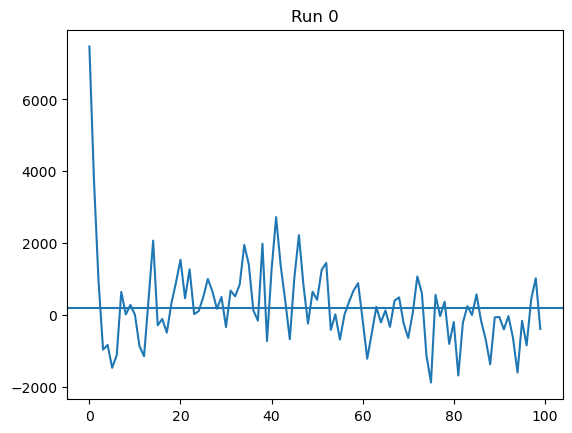

In [33]:
plt.title('Run 0')
plt.plot(stress_dict_300['relaxed_stress_C11'][:,0,0])
plt.axhline(np.mean(stress_dict_300['relaxed_stress_C11'][20:,0,0], axis = 0))
mean_run = np.mean(stress_dict_300['relaxed_stress_C11'][20:,0,0], axis = 0)
mean_run

141.7340813120839

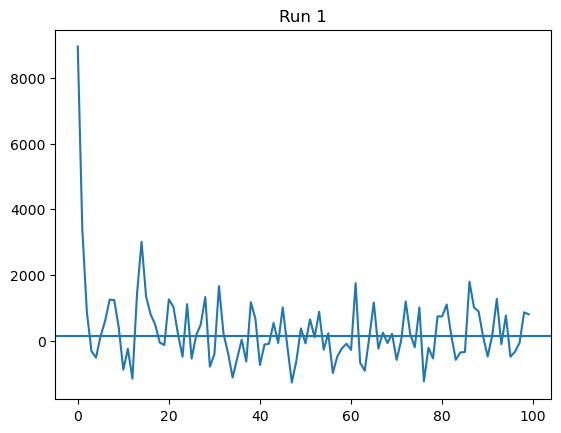

In [32]:
plt.title('Run 1')
plt.plot(stress_dict_300_1['relaxed_stress_C11'][:,0,0])
plt.axhline(np.mean(stress_dict_300_1['relaxed_stress_C11'][20:,0,0], axis = 0))

mean_run_1 = np.mean(stress_dict_300_1['relaxed_stress_C11'][20:,0,0], axis = 0)
mean_run_1

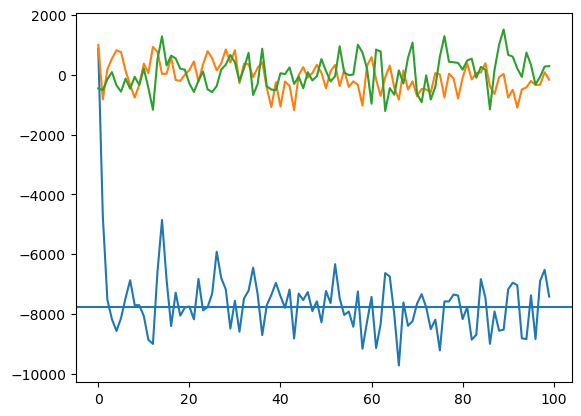

In [75]:
plt.plot(stress_dict_300_1['strained_stress_C11'][:,:,0])
plt.axhline(np.mean(stress_dict_300_1['strained_stress_C11'][20:,0,0], axis = 0))

In [ ]:
plt.plot(np.mean(stress_dict_300_1['relaxed_stress_C11'][:,:,0]))

In [62]:
elastic_constants_list_300_2

[1581674.8486534993, 1198248.1584729487, 703985.7860454394]

In [38]:
elastic_constants_list_300_old, elastic_constants_list_500_old, elastic_constants_list_800_old

([1708047.1698537243, 1200998.912591118, 736383.9337147959],
 [1441135.5664244464, 1122482.3368255557, 673224.0241416948],
 [1406660.9522165915, 1059775.5001629365, 579655.0862127924])

In [39]:
elastic_constants_list_0

[1692164.6750272135, 1214497.7228949314, 762691.2007684121]

## (Jan + Yury)'s function to fit elastic constants

In [40]:
sym_dict, structure_dict = generate_structures_helper(
    structure=relaxed_unit_cell,
    eps_range=0.005,
    num_of_point=5,
    zero_strain_job_name="s_e_0",
    sqrt_eta=True,
)
structure_dict

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/workflows/elastic/symmetry.py:32: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  SGN = dataset["number"]


OrderedDict([('s_e_0',
              Atoms(symbols='Cu4', pbc=True, cell=[3.6150000810785805, 3.6150000810785805, 3.6150000810785805])),
             ('s_01_e_m0_00500',
              Atoms(symbols='Cu4', pbc=True, cell=[3.5968796658126285, 3.5968796658126285, 3.5968796658126285])),
             ('s_01_e_m0_00250',
              Atoms(symbols='Cu4', pbc=True, cell=[3.6059512556700533, 3.6059512556700533, 3.6059512556700533])),
             ('s_01_e_0_00250',
              Atoms(symbols='Cu4', pbc=True, cell=[3.624026312560087, 3.624026312560087, 3.624026312560087])),
             ('s_01_e_0_00500',
              Atoms(symbols='Cu4', pbc=True, cell=[3.6330301185181946, 3.6330301185181946, 3.6330301185181946])),
             ('s_08_e_m0_00500',
              Atoms(symbols='Cu4', pbc=True, cell=[3.5968796658126285, 3.5968796658126285, 3.6150000810785805])),
             ('s_08_e_m0_00250',
              Atoms(symbols='Cu4', pbc=True, cell=[3.6059512556700533, 3.6059512556700533, 3.6150000

In [41]:
df_pot_selected = get_potential_by_name(
    potential_name=potential_name_str
)

result_dict = evaluate_with_lammpslib(
    task_dict={"calc_energy": structure_dict},
    potential_dataframe=df_pot_selected,
)

sym_dict, elastic_dict = analyse_structures_helper(
    output_dict=result_dict,
    sym_dict=sym_dict,
    fit_order=2,
    zero_strain_job_name="s_e_0",
)

sym_dict, elastic_dict

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


({'SGN': 225,
  'v0': 47.24163655365946,
  'LC': 'CI',
  'Lag_strain_list': ['01', '08', '23'],
  'epss': array([-0.005 , -0.0025,  0.    ,  0.0025,  0.005 ]),
  'strain_energy': [[(-0.005, -14.155331549040174),
    (-0.0025, -14.158842895538605),
    (0.0, -14.159999873522768),
    (0.0024999999999999996, -14.158857794361712),
    (0.005, -14.15545249983866)],
   [(-0.005, -14.157811017439585),
    (-0.0025, -14.159456877440729),
    (0.0, -14.159999873522768),
    (0.0024999999999999996, -14.159463637175513),
    (0.005, -14.157865505906283)],
   [(-0.005, -14.156634898702134),
    (-0.0025, -14.159158178385077),
    (0.0, -14.159999873522768),
    (0.0024999999999999996, -14.159156382493132),
    (0.005, -14.156620532355765)]],
  'e0': -14.159999873522768,
  'A2': array([3.90269271, 1.83064058, 2.85545831])},
 {'elastic_matrix': array([[169.74837327, 123.55258251, 123.55258251,   0.        ,
            0.        ,   0.        ],
         [123.55258251, 169.74837327, 123.55258251,  

In [42]:
def fit_elastic_constants(structure: Atoms, potential: str, strains, stresses=None, energies=None):

    sym_dict, structure_dict = generate_structures_helper(
        structure=structure,
        eps_range=0.005,
        num_of_point=5,
        zero_strain_job_name="s_e_0",
        sqrt_eta=True,
    )

    df_pot_selected = get_potential_by_name(
        potential_name=potential
    )

    result_dict = evaluate_with_lammpslib(
        task_dict={"calc_energy": structure_dict},
        potential_dataframe=df_pot_selected,
    )

    sym_dict, elastic_dict = analyse_structures_helper(
        output_dict=result_dict,
        sym_dict=sym_dict,
        fit_order=2,
        zero_strain_job_name="s_e_0",
    )

    return elastic_dict

In [43]:
relaxed_structure = get_relaxed_structure_at_0K(unit_cell, potential_name_str)
elast_dict = fit_elastic_constants(
    structure=relaxed_structure,
    potential=potential_name_str,
    strains=None)

/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/workflows/elastic/symmetry.py:32: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  SGN = dataset["number"]
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst
/cmmc/ptmp/pyironhb/pyiron_latest_env/lib/python3.11/site-packages/atomistics/calculators/lammps/helpers.py:29: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  lmp.interactive_structure_setter(


In [44]:
elast_dict['elastic_matrix']

array([[169.74837327, 123.55258251, 123.55258251,   0.        ,
          0.        ,   0.        ],
       [123.55258251, 169.74837327, 123.55258251,   0.        ,
          0.        ,   0.        ],
       [123.55258251, 123.55258251, 169.74837327,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  76.24914297,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         76.24914297,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  76.24914297]])

In [44]:
def get_bulk_structure(
    name: str,
    crystalstructure=None,
    a=None,
    b=None,
    c=None,
    alpha=None,
    covera=None,
    u=None,
    orthorhombic=False,
    cubic=False,
    basis=None,
):
    from ase.build import bulk
    equil_struct = bulk(
        name=name,
        crystalstructure=crystalstructure,
        a=a,
        b=b,
        c=c,
        alpha=alpha,
        covera=covera,
        u=u,
        orthorhombic=orthorhombic,
        cubic=cubic,
        basis=basis,
    )
    return equil_struct